[View in Colaboratory](https://colab.research.google.com/github/orico/PCAvsAutoencoder/blob/master/PCA_vs_Autoencoder_tutorial.ipynb)

In this tutorial I will explain about the relation between PCA and an Autoencoder (AE). I assume that you have a basic grasp of what PCA and AE are, but if you are not familiar PCA or autoencoders please read [1,2]. 

A lot have been written about using a linearly activated autoencoder (AE) to approximate principal component analysis (PCA). From a math point of view, minimizing the reconstruction error in PCA is the same as AE [3]. 

However, why limit ourselves to linear transformations? Neural nets are very flexible, therefore we can introduce non-linearities by using non-linear activation functions [4]. Additionally, with an increasing amount of features, PCA will result in slower processing compared with an AE. Our Hypothesis is that the subspace spanned by the AE will be similar to the one found by PCA [5]. 

In this study we'll see the similarities and differences between PCA, a linear and non-linear autoencoders. Please note that a non-linear AE will be non-linear except when the input data is spanned linearly.


In [1]:
import keras
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Model, load_model
from keras.layers import Input, Dense
from keras.callbacks import ModelCheckpoint
from keras import regularizers
from keras.optimizers import Adam
from keras import regularizers
from sklearn import datasets
from sklearn import decomposition
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
from sklearn import metrics

%matplotlib inline

RANDOM_SEED = 37117
np.random.seed(RANDOM_SEED)

Using TensorFlow backend.


First, lets load up the Iris data-set and scale it between [0,1].

In [0]:
iris = datasets.load_iris()
X = iris.data
y = iris.target
target_names = iris.target_names

scaler = MinMaxScaler()
scaler.fit(X)
X_scaled = scaler.transform(X)

In [0]:
def plot3clusters(X, title, vtitle):
  plt.figure()
  colors = ['navy', 'turquoise', 'darkorange']
  lw = 2

  for color, i, target_name in zip(colors, [0, 1, 2], target_names):
      plt.scatter(X[y == i, 0], X[y == i, 1], color=color, alpha=1., lw=lw,
                  label=target_name)
  plt.legend(loc='best', shadow=False, scatterpoints=1)
  plt.title(title)  
  plt.xlabel(vtitle + "1")
  plt.ylabel(vtitle + "2")
  plt.show()

Then we use the data-set to fit a PCA and plot the first two PCs against each other. We can see that two big blobs emerge, using the target labels we can see how the three clusters are contained within those two blobs. 

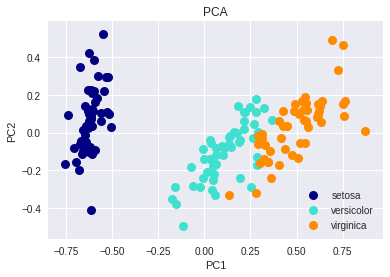

In [5]:
pca = decomposition.PCA()
pca_transformed = pca.fit_transform(X_scaled)
plot3clusters(pca_transformed[:,:2], 'PCA', 'PC')  

Our first network is a linear AE that has 3 layers (encoding, hidden and decoding), the encoding and decoding layers have 'linear activations' and the hidden layer has two neurons. Essentially this structure approximates PCA by reducing the data from four features to two features in the hidden layer. As you can see the model converges quite nicely and our validation loss has dropped to zero. After passing the training data through the hidden layer we get two new vectors and by plotting them against each other we clearly blob and cluster formation similar to PCA. 

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 4)                 0         
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 10        
_________________________________________________________________
dense_4 (Dense)              (None, 4)                 12        
Total params: 22
Trainable params: 22
Non-trainable params: 0
_________________________________________________________________
None


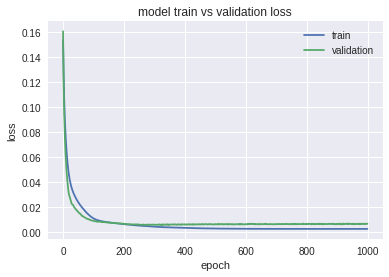

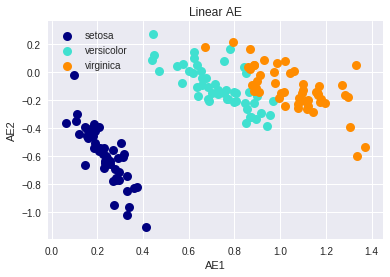

In [8]:
#create an AE and fit it with our data using 3 neurons in the dense layer using keras' functional API
input_dim = X_scaled.shape[1]
encoding_dim = 2  
input_img = Input(shape=(input_dim,))
encoded = Dense(encoding_dim, activation='linear')(input_img)
decoded = Dense(input_dim, activation='linear')(encoded)
autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='mse')
print(autoencoder.summary())

history = autoencoder.fit(X_scaled, X_scaled,
                epochs=1000,
                batch_size=16,
                shuffle=True,
                validation_split=0.1,
                verbose = 0)

#plot our loss 
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model train vs validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

# use our encoded layer to encode the training input
encoder = Model(input_img, encoded)
encoded_input = Input(shape=(encoding_dim,))
decoder_layer = autoencoder.layers[-1]
decoder = Model(encoded_input, decoder_layer(encoded_input))
encoded_data = encoder.predict(X_scaled)

plot3clusters(encoded_data[:,:2], 'Linear AE', 'AE')  


In [10]:
labels_true = y 
titles = ['PCA', 'Linear AE']
for n_clusters_ in [2]:
  estimators = [('PCA'    , KMeans(n_clusters=n_clusters_), pca_transformed),
                ('AE linear' , KMeans(n_clusters=n_clusters_), encoded_data)]

  print(type(y))
  for name, est, data in estimators:
      X = data
      est.fit(X)
      labels = est.labels_
      print(name,':')
      print(labels[:]) 
      print('Estimated number of clusters: %d' % n_clusters_)
      print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels_true, labels))
      print("Completeness: %0.3f" % metrics.completeness_score(labels_true, labels))
      print("V-measure: %0.3f" % metrics.v_measure_score(labels_true, labels))
      print("Adjusted Rand Index: %0.3f"
            % metrics.adjusted_rand_score(labels_true, labels))
      print("Adjusted Mutual Information: %0.3f"
            % metrics.adjusted_mutual_info_score(labels_true, labels))
      print("Silhouette Coefficient: %0.3f"
            % metrics.silhouette_score(X, labels))
      print()
  print()
  print('----------------------------------------------------------------------------------')
  print()

<class 'numpy.ndarray'>
PCA :
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0]
Estimated number of clusters: 2
Homogeneity: 0.579
Completeness: 1.000
V-measure: 0.734
Adjusted Rand Index: 0.568
Adjusted Mutual Information: 0.577
Silhouette Coefficient: 0.629

AE linear :
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0]
Estimated number of clusters: 2
Homogeneity: 0.579
Completeness: 1.000
V-measure: 0.734
Adjusted Rand Index: 0.568
Adjusted Mutual Information: 0.577
Silhouette Coef

Lets create a second AE, this time we'll replace both linear activation functions with a sigmoid. This network structure can be thought of PCA with non-linear transformation and similarly to the one above it converges to a local minimum and we can plot the resulting dense-vectors. 

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 4)                 0         
_________________________________________________________________
dense_5 (Dense)              (None, 2)                 10        
_________________________________________________________________
dense_6 (Dense)              (None, 4)                 12        
Total params: 22
Trainable params: 22
Non-trainable params: 0
_________________________________________________________________
None


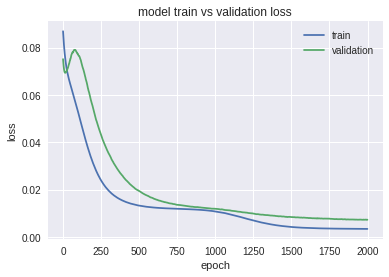

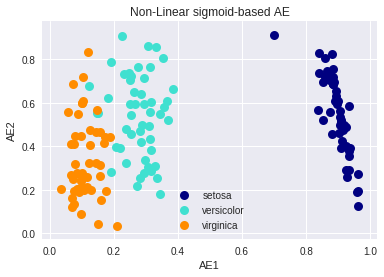

In [11]:
#create an AE and fit it with our data using 3 neurons in the dense layer using keras' functional API
input_dim2 = X_scaled.shape[1]
encoding_dim2 = 2  
input_img2 = Input(shape=(input_dim2,))
encoded2 = Dense(encoding_dim2, activation='sigmoid')(input_img2)
decoded2 = Dense(input_dim2, activation='sigmoid')(encoded2)
autoencoder2 = Model(input_img2, decoded2)
autoencoder2.compile(optimizer='adam', loss='mse')
print(autoencoder2.summary())

history2 = autoencoder2.fit(X_scaled, X_scaled,
                epochs=2000,
                batch_size=16,
                shuffle=True,
                validation_split=0.1,
                verbose = 0)

#plot our loss 
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('model train vs validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

# use our encoded layer to encode the training input
encoder2 = Model(input_img2, encoded2)
encoded_input2 = Input(shape=(encoding_dim2,))
decoder_layer2 = autoencoder2.layers[-1]
decoder2 = Model(encoded_input2, decoder_layer2(encoded_input2))
encoded_data2 = encoder2.predict(X_scaled)

plot3clusters(encoded_data2[:,:2], 'Non-Linear sigmoid-based AE', 'AE')  


Our last AE uses relu activation with an L1 regularizer. It is another way of saying that we want to approximate PCA by using a non-linear AE with constrained representations [2]. Similarly to the Previous networks it converges to a local minimum and both dense-vectors show three blusters contained in two blobs.

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        (None, 4)                 0         
_________________________________________________________________
dense_11 (Dense)             (None, 2)                 10        
_________________________________________________________________
dense_12 (Dense)             (None, 4)                 12        
Total params: 22
Trainable params: 22
Non-trainable params: 0
_________________________________________________________________
None


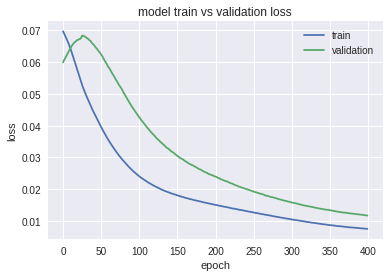

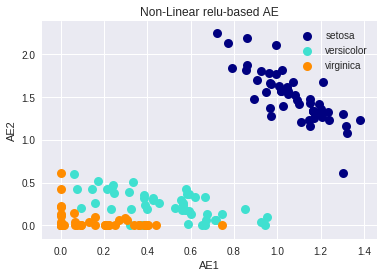

In [14]:
#create an AE and fit it with our data using 3 neurons in the dense layer using keras' functional API
input_dim3 = X_scaled.shape[1]
encoding_dim3 = 2  
input_img3 = Input(shape=(input_dim3,))
encoded3 = Dense(encoding_dim3, activation='relu', activity_regularizer=regularizers.l1(10e-5))(input_img3)
decoded3 = Dense(input_dim3, activation='sigmoid')(encoded3)
autoencoder3 = Model(input_img3, decoded3)
autoencoder3.compile(optimizer='adam', loss='mse')
print(autoencoder3.summary())

history3 = autoencoder3.fit(X_scaled, X_scaled,
                epochs=400,
                batch_size=16,
                shuffle=True,
                validation_split=0.1,
                verbose = 0)

#plot our loss 
plt.plot(history3.history['loss'])
plt.plot(history3.history['val_loss'])
plt.title('model train vs validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

# use our encoded layer to encode the training input
encoder3 = Model(input_img3, encoded3)
encoded_input3 = Input(shape=(encoding_dim3,))
decoder_layer3 = autoencoder3.layers[-1]
decoder3 = Model(encoded_input3, decoder_layer3(encoded_input3))
encoded_data3 = encoder3.predict(X_scaled)

plot3clusters(encoded_data3[:,:2], 'Non-Linear relu-based AE', 'AE')  


After training all 3 autoencoders and pushing our training data through the hidden layer, we compare the first 2 PCs and the AE’s dense features. We can clearly see that the figures in these vectors are not the same, across all models. This is very clear from plotting each two vectors and looking at the resulting clusters. Next we would like to compare how a simple KMEANS with 2 clusters classifies the data.

In [15]:
print('PCA\n',pca_transformed[:,0:2][0:10])
print()
print('Linear AE\n',encoded_data[0:10])
print()
print('Nonlinear AE with sigmoid\n',encoded_data2[0:10])
print()
print('Nonlinear AE with relu\n',encoded_data3[0:10])


PCA
 [[-0.63036125  0.11155626]
 [-0.62354631 -0.1003132 ]
 [-0.6697928  -0.04722006]
 [-0.65463305 -0.09879127]
 [-0.64826327  0.13755769]
 [-0.534057    0.29322304]
 [-0.65639589  0.01492194]
 [-0.62564396  0.06107532]
 [-0.67652584 -0.19648232]
 [-0.64613717 -0.06324223]]

Linear AE
 [[ 0.23598923 -0.6469984 ]
 [ 0.1800067  -0.39132446]
 [ 0.15926996 -0.4707053 ]
 [ 0.15585978 -0.40266344]
 [ 0.22946599 -0.6839787 ]
 [ 0.35961363 -0.82653046]
 [ 0.18559463 -0.53790534]
 [ 0.2248888  -0.58437693]
 [ 0.11058816 -0.2936817 ]
 [ 0.17480673 -0.44444498]]

Nonlinear AE with sigmoid
 [[0.91792077 0.4988284 ]
 [0.85968477 0.71589184]
 [0.88740337 0.6970919 ]
 [0.86628693 0.7467765 ]
 [0.9257194  0.487611  ]
 [0.92530775 0.28976613]
 [0.89203835 0.6544596 ]
 [0.9049678  0.5603036 ]
 [0.83925694 0.82819325]
 [0.88463604 0.6867349 ]]

Nonlinear AE with relu
 [[1.0436548 1.617722 ]
 [1.1459521 1.2238551]
 [1.2010672 1.3515487]
 [1.2407831 1.2337388]
 [1.0709138 1.6741986]
 [0.8564586 1.8071246]

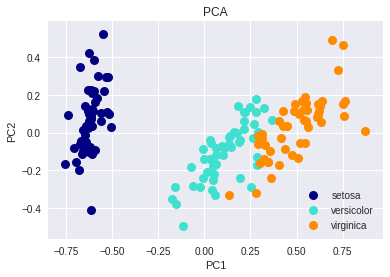

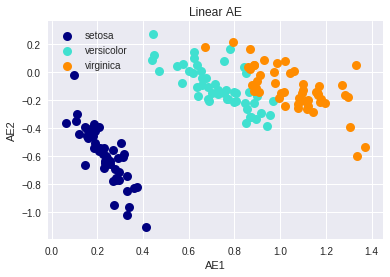

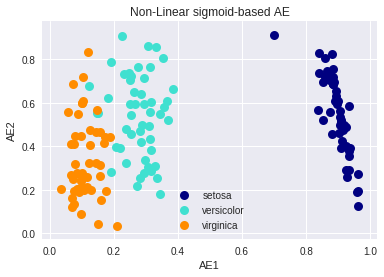

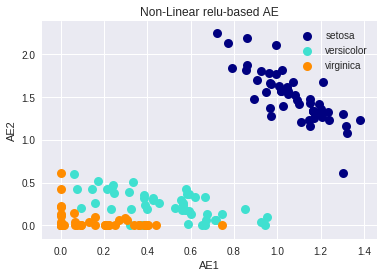

In [16]:
plot3clusters(pca_transformed[:,:2], 'PCA', 'PC')  
plot3clusters(encoded_data[:,:2], 'Linear AE', 'AE')  
plot3clusters(encoded_data2[:,:2], 'Non-Linear sigmoid-based AE', 'AE')  
plot3clusters(encoded_data3[:,:2], 'Non-Linear relu-based AE', 'AE')  

We would like to know if each result, clustered with KMEANS (k=2 & 3), can label the data similarly across all models, even if the dense range is very different. The following is a printed classification vector for the samples in the training set. The printed output clearly shows, that using different dense representation that were created by different algorithms, can be clustered into two identical clusters. We can see that the metric scores are mostly identical when clustering the two blobs, and very close when clustering for the three known flower classes. 
Please note that minor differences can happen due to the random nature of neural networks.

In [18]:
labels_true = y 
titles = ['PCA', 'Linear AE', 'Sigmoid AE', 'Relu AE']
for n_clusters_ in [2,3]:
  estimators = [('PCA'    , KMeans(n_clusters=n_clusters_), pca_transformed),
                ('AE linear' , KMeans(n_clusters=n_clusters_), encoded_data),
                ('AE sigmoid' , KMeans(n_clusters=n_clusters_), encoded_data2),
                ('AE relu', KMeans(n_clusters=n_clusters_), encoded_data3)]

  print(type(y))
  print('Number of clusters: %d' % n_clusters_)
  for name, est, data in estimators:
      X = data
      est.fit(X)
      labels = est.labels_
      print(name,':')
      print(labels[:]) 
      print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels_true, labels))
      print("Completeness: %0.3f" % metrics.completeness_score(labels_true, labels))
      print("V-measure: %0.3f" % metrics.v_measure_score(labels_true, labels))
      print("Adjusted Rand Index: %0.3f"
            % metrics.adjusted_rand_score(labels_true, labels))
      print("Adjusted Mutual Information: %0.3f"
            % metrics.adjusted_mutual_info_score(labels_true, labels))
      print("Silhouette Coefficient: %0.3f"
            % metrics.silhouette_score(X, labels))
      print()
  print()
  print('----------------------------------------------------------------------------------')
  print()

<class 'numpy.ndarray'>
Number of clusters: 2
PCA :
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1]
Homogeneity: 0.579
Completeness: 1.000
V-measure: 0.734
Adjusted Rand Index: 0.568
Adjusted Mutual Information: 0.577
Silhouette Coefficient: 0.629

AE linear :
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1]
Homogeneity: 0.579
Completeness: 1.000
V-measure: 0.734
Adjusted Rand Index: 0.568
Adjusted Mutual Information: 0.577
Silhouette Coefficient: 0.647

AE sigmoid :
[1 1 1 1 1 1 

I would like to thank Natanel Davidovits and Gal Yona for their invaluable critique, proof-reading and comments.

Ori Cohen has done his PhD in computer science in the fields of machine learning, brain-computer-interface and neurobiology.

References:

[1] [building AE in keras](https://blog.keras.io/building-autoencoders-in-keras.html)

[2] [PCA in 3 steps using Iris](http://sebastianraschka.com/Articles/2015_pca_in_3_steps.html)

[3] [CSC 411: Lecture 14: Principal Components Analysis &
Autoencoders](https://www.cs.toronto.edu/~urtasun/courses/CSC411/14_pca.pdf), page 16.

[4] [A Tutorial on Autoencoders for Deep Learning](https://lazyprogrammer.me/a-tutorial-on-autoencoders/)

[5] [what are the differences between pca and autoencoder](https://stats.stackexchange.com/questions/120080/whatre-the-differences-between-pca-and-autoencoder) 